In [1]:
import os
import pandas as pd
import openai
import tiktoken
from PyPDF2 import PdfReader
from tqdm import tqdm
from dotenv import load_dotenv

In [2]:
# 讀取 .env 設定
load_dotenv()
openai.api_key = os.environ['OPENAI_API_KEY']

In [3]:
# 讀取 Excel 檔案，包含 91 個問題及其標籤
excel_path = "data/tcfd第四層揭露指引.xlsx"
df_questions = pd.read_excel(excel_path)

In [4]:
df_questions

,Label,Definition
0,G-1-1_1,公司是否描述向董事會和/或董事會下設委員會，定期報告氣候相關風險與機會之流程？
1,G-1-1_2,公司是否描述向董事會和/或董事會下設委員會，報告氣候相關風險與機會之頻率？
2,G-1-2_3,公司是否描述董事會和/或董事會下設委員會，在監督和指導策略、重要行動計畫、風險管理政策、年度...
3,G-1-2_4,公司是否描述董事會和/或董事會下設委員會，在監督重要資本支出、企業收購和撤資時，考量氣候相關...
4,G-1-3_5,公司是否描述董事會或其所屬和/或指派之委員會如何監督風險與機會目標之實現？
...,...,...
86,MT-3-2_78,公司設定目標時，是否有描述衡量進度情況的基準年份？
87,MT-3-2_79,公司設定目標時，是否有描述評估目標進展情況的重要績效指標？
88,MT-3-3_80,公司是否依總體或業務劃分揭露中期目標？
89,MT-3-3_81,公司是否依總體或業務劃分揭露長期目標？


In [5]:
# 假設 Excel 檔案有 'Label' 和 'Question' 欄位
questions = df_questions[['Label', 'Definition']].dropna().values.tolist()

In [6]:
questions

[['G-1-1_1', '公司是否描述向董事會和/或董事會下設委員會，定期報告氣候相關風險與機會之流程？'],
 ['G-1-1_2', '公司是否描述向董事會和/或董事會下設委員會，報告氣候相關風險與機會之頻率？'],
 ['G-1-2_3',
  '公司是否描述董事會和/或董事會下設委員會，在監督和指導策略、重要行動計畫、風險管理政策、年度預算和營業計畫、公司的營業目標、計畫實施和執行情況時，考量氣候相關風險與機會？'],
 ['G-1-2_4', '公司是否描述董事會和/或董事會下設委員會，在監督重要資本支出、企業收購和撤資時，考量氣候相關風險與機會？'],
 ['G-1-3_5', '公司是否描述董事會或其所屬和/或指派之委員會如何監督風險與機會目標之實現？'],
 ['G-2-1_6', '公司是否描述已分派氣候相關責任給管理職位或委員會？'],
 ['G-2-1_7', '公司是否描述該管理職位或委員會向董事會或董事會下設委員會進行報告？'],
 ['G-2-1_8', '公司是否描述已分派之職責包含評估和/或管理氣候相關風險與機會？'],
 ['G-2-2_9', '公司是否有對氣候相關組織結構之描述？'],
 ['G-2-2_10', '公司是否描述有跨部門之氣候相關工作小組統籌執行相關工作？'],
 ['G-2-3_11', '公司是否描述執行管理階層掌握氣候相關風險與機會之流程？'],
 ['G-2-4_12', '公司是否提供管理階層透過特定職位監控氣候相關風險與機會之說明？'],
 ['G-2-4_13', '公司是否提供管理階層透過委員會監控氣候相關風險與機會之說明？'],
 ['S-1-1_14', '公司是否描述「短期」的氣候相關風險與機會，並考量其資產或基礎設施的使用壽命？'],
 ['S-1-1_15',
  '公司是否描述「中期」的氣候相關風險與機會，並考量其資產或基礎設施的使用壽命，以及中期對公司與供應鏈潛在的氣候相關風險與機會？'],
 ['S-1-1_16',
  '公司是否描述「長期」的氣候相關風險與機會，並考量其資產或基礎設施的使用壽命，以及長期對公司與供應鏈潛在的氣候相關風險與機會？'],
 ['S-1-2_17', '公司應描述在「短期」的時間長度下，可能會產生重大財務影響的氣候相關風險與機會？'],
 ['S-1

In [7]:
# 設定 GPT 模型的 Token 限制
MODEL_NAME = "gpt-4o-mini"
MAX_TOKENS = 4096  # OpenAI 最大 Token 限制（請根據 API 規格調整）
OVERLAP_TOKENS = 100  # Overlap token 數量

In [8]:
# 初始化 Token 計數器
tokenizer = tiktoken.encoding_for_model(MODEL_NAME)

In [9]:
def count_tokens(text):
    return len(tokenizer.encode(text))

def split_text(text, max_tokens, overlap_tokens):
    """根據 Token 限制分割文本，確保有重疊部分"""
    words = text.split()
    chunks = []
    start = 0

    while start < len(words):
        end = start + max_tokens
        chunk = " ".join(words[start:end])
        chunks.append(chunk)
        start = end - overlap_tokens  # Overlap 設定

    return chunks

def extract_text_from_pdf(pdf_path):
    """從 PDF 提取文字"""
    with open(pdf_path, "rb") as file:
        reader = PdfReader(file)
        text = "\n".join([page.extract_text() for page in reader.pages if page.extract_text()])
    return text

def query_gpt(chunk, question):
    prompt = f"""

    ### 任務 ###
    根據以下內容判斷此報告書是否有回答"{question}"的敘述：{chunk}

    ### 回覆格式 ###
    如果報告書中有做到 "{question}"，回覆 "Yes"。
    如果報告書中沒有做到 "{question}"，回覆 "No"。
    """
    try:
        response = openai.chat.completions.create(
            model=MODEL_NAME,
            messages=[
                {"role": "system", "content": "You are an expert in climate-related financial disclosures."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=10
        )
        # Access the message content
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"Error querying OpenAI: {e}")
        return "Error"

In [10]:
# 設定 PDF 來源資料夾
pdf_folder = "data/tcfd_report_pdf_for_testing"
output_data = []

In [11]:
# 遍歷所有 PDF 報告
for pdf_file in tqdm(os.listdir(pdf_folder)):
    if not pdf_file.endswith(".pdf"):
        continue

    pdf_path = os.path.join(pdf_folder, pdf_file)
    text = extract_text_from_pdf(pdf_path)

    # 分割文本
    chunks = split_text(text, MAX_TOKENS, OVERLAP_TOKENS)

    for chunk_id, chunk in enumerate(chunks):
        for label, question in questions:
            answer = query_gpt(chunk, question)
            output_data.append([pdf_file, chunk_id, label, question, answer])

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [1:01:48<00:00, 618.04s/it]


In [12]:
# 儲存結果到 CSV
output_df = pd.DataFrame(output_data, columns=["Report", "Chunk ID", "Label", "Question", "Answer"])
output_df.to_csv("data/llm_question_answering_results/tcfd_gpt_results.csv", index=False)

print("處理完成，結果已儲存至 data/llm_question_answering_results/tcfd_gpt_results.csv")

處理完成，結果已儲存至 data/llm_question_answering_results/tcfd_gpt_results.csv


### Data Analysis

In [1]:
import pandas as pd

In [2]:
# 讀取上傳的 CSV 檔案
file_path = "data/llm_question_answering_results/tcfd_gpt_results.csv"
df = pd.read_csv(file_path)

# 檢視前幾行資料
df.head()

,Report,Chunk ID,Label,Question,Answer
0,富邦金控_2022_TCFD_報告書_preprocessed.pdf,0,G-1-1_1,公司是否描述向董事會和/或董事會下設委員會，定期報告氣候相關風險與機會之流程？,Yes
1,富邦金控_2022_TCFD_報告書_preprocessed.pdf,0,G-1-1_2,公司是否描述向董事會和/或董事會下設委員會，報告氣候相關風險與機會之頻率？,Yes
2,富邦金控_2022_TCFD_報告書_preprocessed.pdf,0,G-1-2_3,公司是否描述董事會和/或董事會下設委員會，在監督和指導策略、重要行動計畫、風險管理政策、年度...,Yes
3,富邦金控_2022_TCFD_報告書_preprocessed.pdf,0,G-1-2_4,公司是否描述董事會和/或董事會下設委員會，在監督重要資本支出、企業收購和撤資時，考量氣候相關...,Yes
4,富邦金控_2022_TCFD_報告書_preprocessed.pdf,0,G-1-3_5,公司是否描述董事會或其所屬和/或指派之委員會如何監督風險與機會目標之實現？,Yes


In [3]:
# 解析 Report 欄位取得 Institution 和 Year
df[['Institution', 'Year']] = df['Report'].str.extract(r'(.+?)_(\d{4})_')

# 解析 Label 欄位取得底線後的部分
df['Label'] = df['Label'].str.split('_').str[-1]

# 只保留需要的欄位並重新排列
df_final = df[['Institution', 'Year', 'Label', 'Answer']]

In [4]:
df_final

,Institution,Year,Label,Answer
0,富邦金控,2022,1,Yes
1,富邦金控,2022,2,Yes
2,富邦金控,2022,3,Yes
3,富邦金控,2022,4,Yes
4,富邦金控,2022,5,Yes
...,...,...,...,...
814,開發金控,2021,78,No
815,開發金控,2021,79,No
816,開發金控,2021,80,No
817,開發金控,2021,81,No


In [5]:
answer_file_path = "data/answer/rank.xlsx"
answer_df = pd.read_excel(answer_file_path)

# 檢視前幾行資料
answer_df

,Symbol,Financial_Institutions,Format,Year,1,2,3,4,5,6,...,R_2,R_3,MT_1,MT_2,MT_3,G,S,R,MT,Disclosure
0,2881,富邦金,1.0,2022,Y,Y,Y,Y,Y,Y,...,0.833333,1.0,0.833333,1.000000,1.0000,0.937500,0.972222,0.911111,0.944444,0.941319
1,5880,合庫金,1.0,2022,Y,Y,Y,Y,Y,Y,...,1.000000,1.0,0.541667,1.000000,1.0000,1.000000,0.913889,1.000000,0.847222,0.940278
2,5849,永豐銀行,1.0,2022,Y,Y,Y,N,Y,Y,...,1.000000,1.0,0.645833,0.888889,1.0000,0.854167,0.975000,0.866667,0.844907,0.885185
3,2891,中信金,1.0,2022,Y,Y,Y,N,Y,Y,...,1.000000,0.5,0.645833,0.888889,0.7500,0.916667,0.972222,0.833333,0.761574,0.870949
4,2884,玉山金,1.0,2022,Y,Y,Y,N,Y,Y,...,0.833333,1.0,0.625000,1.000000,0.7500,0.916667,0.813889,0.944444,0.791667,0.866667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,2880,華南金,2.0,2022,Y,Y,N,N,N,N,...,0.000000,0.0,0.187500,0.666667,0.6250,0.166667,0.161111,0.133333,0.493056,0.238542
76,2889,國票金,2.0,2021,N,N,Y,N,Y,Y,...,0.000000,0.0,0.208333,0.000000,0.3125,0.416667,0.100000,0.000000,0.173611,0.172569
77,2893,新光銀行,2.0,2021,N,N,N,N,N,N,...,0.000000,0.0,0.166667,0.666667,0.0000,0.000000,0.155556,0.066667,0.277778,0.125000
78,6039,將來銀行,NaN,2022,Y,Y,Y,N,N,Y,...,0.000000,0.5,0.041667,0.000000,0.3125,0.687500,0.361111,0.300000,0.118056,0.366667


In [6]:
# 使用 pivot_table 來處理重複值問題
df_pivot = df_final.pivot_table(index=['Institution', 'Year'], columns='Label', values='Answer', aggfunc='first')

# 重置索引，使表格更加清晰
df_pivot.reset_index(inplace=True)

# 調整欄位名稱
df_pivot.columns.name = None  # 移除 columns 名稱
df_pivot.rename(columns={'Institution': 'Financial_Institutions'}, inplace=True)

In [7]:
df_pivot

,Financial_Institutions,Year,#MT1,#MT2,#MT3,#MT4,#MT5,#R1,#R2,#S1,...,75,76,77,78,79,8,80,81,82,9
0,富邦金控,2022,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes
1,新光金控,2022,Yes,No,Yes,Yes,Yes,Yes,Yes,No,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes
2,永豐銀行,2022,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,...,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,No,Yes
3,瑞興銀行,2022,Yes,No,No,Yes,Yes,Yes,No,Yes,...,No,Yes,Yes,Yes,No,Yes,Yes,Yes,No,Yes
4,華泰銀行,2022,Yes,Yes,No,Yes,Yes,Yes,Yes,No,...,No,No,Yes,Yes,Yes,Yes,Yes,Yes,No,Yes
5,開發金控,2021,Yes,No,Yes,Yes,Yes,Yes,Yes,No,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes


In [8]:
import pandas as pd
import numpy as np

In [9]:
# 1. 將兩個 DataFrame 的欄位名稱都轉換為字串，避免格式不一致的問題
df_pivot.columns = df_pivot.columns.astype(str)
answer_df.columns = answer_df.columns.astype(str)

# 2. 建立 answer_df 的查找字典，key 為 (Financial_Institutions, Year)（皆以字串表示）
answer_lookup = {}
for idx, row in answer_df.iterrows():
    key = (str(row['Financial_Institutions']), str(row['Year']))
    answer_lookup[key] = row
# 3. 定義識別欄位
id_cols = ['Financial_Institutions', 'Year']

# 4. 找出 df_pivot 中除了識別欄位之外，且在 answer_df 中也有的共同欄位
answer_cols_str = [str(x) for x in answer_df.columns]
common_columns = [str(col) for col in df_pivot.columns 
                  if str(col) not in id_cols and str(col) in answer_cols_str]

print("共同比對的欄位：", common_columns)  # 理論上應有 91 個欄位
print(len(common_columns))
# 初始化全體計數器
correct_count = 0
total_count = 0

# 初始化每個 institution 的計數字典
inst_results = {}  # 格式：{ institution: {'correct': ..., 'total': ...}, ... }

# 初始化記錄每個 institution 答錯的題目明細
inst_errors = {}   # 格式：{ institution: [ { 'Year': ..., 'Question': ..., 'Pivot Answer': ..., 'Correct Answer': ... }, ... ] }

# 5. 逐列比對
for idx, pivot_row in df_pivot.iterrows():
    # 取得 institution 字串
    institution = str(pivot_row['Financial_Institutions'])
    # 若名稱含有 "金控"（判斷 index 2 到 4 為 "金控"），則轉換為前兩個字 + "金"
    if institution[2:4] == "金控":
        institution = institution[0:2] + "金"
        
    # 以 institution 與 Year 組成 key
    key = (institution, str(pivot_row['Year']))
    if key not in answer_lookup:
        print(f"注意：找不到 {key} 對應於 answer_df 中的資料，跳過 df_pivot 第 {idx} 列。")
        continue
    answer_row = answer_lookup[key]
    print(answer_row)
    # 若該 institution 尚未初始化則先建一個 entry
    if institution not in inst_results:
        inst_results[institution] = {'correct': 0, 'total': 0}
    if institution not in inst_errors:
        inst_errors[institution] = []
    
    # 對所有共同欄位進行比對
    for col in common_columns:
        pivot_val = pivot_row[col]
        # 將 df_pivot 中的答案轉換為 "Y" 或 "N"
        if pivot_val == "Yes":
            pivot_mapped = "Y"
        elif pivot_val == "No":
            pivot_mapped = "N"
        else:
            # 若 pivot_val 不為 "Yes"/"No"，則跳過這題
            continue

        # 取得 answer_df 中對應的答案，並以字串形式處理
        answer_val = str(answer_row[col])
        # 若 answer_df 中該欄位為空值（NaN），或轉換後為字串 'nan'，則跳過計算
        if pd.isna(answer_row[col]) or answer_val.lower() == 'nan':
            continue
        
        total_count += 1
        inst_results[institution]['total'] += 1
        
        # 若答案正確則計數，若不正確則記錄錯誤明細
        if pivot_mapped == answer_val:
            correct_count += 1
            inst_results[institution]['correct'] += 1
        else:
            # 記錄錯誤的題目明細
            inst_errors[institution].append({
                'Year': pivot_row['Year'],
                'Question': col,
                'Pivot Answer': pivot_mapped,
                'Correct Answer': answer_val
            })

共同比對的欄位： ['#MT1', '#MT2', '#MT3', '#MT4', '#MT5', '#R1', '#R2', '#S1', '#S2', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '9']
91
Symbol                        2881
Financial_Institutions         富邦金
Format                         1.0
Year                          2022
1                                Y
                            ...   
G                           0.9375
S                         0.972222
R                         0.911111
MT                        0.944444
Disclosure                0.941319
Name: 0, Length: 249, dtype: object
Symbol         

In [10]:
# 計算全體準確率
accuracy = correct_count / total_count if total_count > 0 else np.nan

print("總比對題數：", total_count)
print("正確題數：", correct_count)
print("全體準確率：", accuracy)

總比對題數： 536
正確題數： 399
全體準確率： 0.7444029850746269


In [11]:
# 計算並印出每個 institution 的準確率
print("各家Institution的準確率：")
for inst, counts in inst_results.items():
    inst_accuracy = counts['correct'] / counts['total'] if counts['total'] > 0 else np.nan
    print(f"{inst}: {inst_accuracy}")

各家Institution的準確率：
富邦金: 0.8666666666666667
新光金: 0.7727272727272727
永豐銀行: 0.8222222222222222
瑞興銀行: 0.5568181818181818
華泰銀行: 0.7888888888888889
開發金: 0.6555555555555556


In [12]:
# 印出每個 institution 答錯的題目明細
print("每家 institution 答錯的題目明細：")
for inst, errors in inst_errors.items():
    if errors:  # 若該 institution 有答錯
        print(f"\nInstitution: {inst} Year: {errors[0]['Year']}")
        for err in errors:
            print(f" Question: {err['Question']},  Pivot Answer: {err['Pivot Answer']},  Correct Answer: {err['Correct Answer']}")
    else:
        print(f"\nInstitution: {inst} 沒有答錯的題目。")

每家 institution 答錯的題目明細：

Institution: 富邦金 Year: 2022
 Question: #MT2,  Pivot Answer: N,  Correct Answer: Y
 Question: 10,  Pivot Answer: Y,  Correct Answer: N
 Question: 22,  Pivot Answer: N,  Correct Answer: Y
 Question: 26,  Pivot Answer: N,  Correct Answer: Y
 Question: 31,  Pivot Answer: Y,  Correct Answer: N
 Question: 45,  Pivot Answer: N,  Correct Answer: Y
 Question: 47,  Pivot Answer: Y,  Correct Answer: N
 Question: 52,  Pivot Answer: Y,  Correct Answer: N
 Question: 59,  Pivot Answer: N,  Correct Answer: Y
 Question: 61,  Pivot Answer: N,  Correct Answer: Y
 Question: 64,  Pivot Answer: N,  Correct Answer: Y
 Question: 65,  Pivot Answer: N,  Correct Answer: Y

Institution: 新光金 Year: 2022
 Question: #MT3,  Pivot Answer: Y,  Correct Answer: N
 Question: #MT4,  Pivot Answer: Y,  Correct Answer: N
 Question: #S1,  Pivot Answer: N,  Correct Answer: Y
 Question: 21,  Pivot Answer: Y,  Correct Answer: N
 Question: 26,  Pivot Answer: N,  Correct Answer: Y
 Question: 28,  Pivot Answe

Visualization

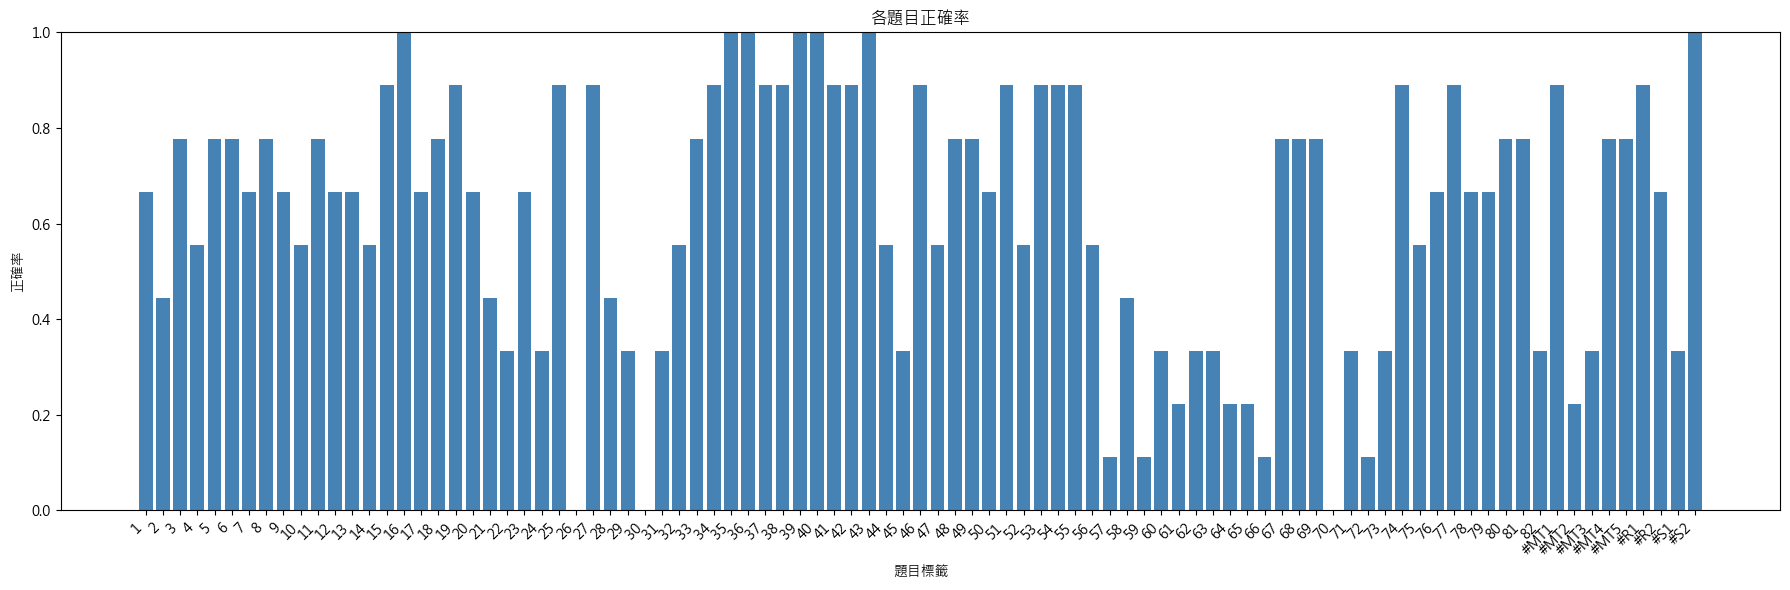

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# 假設你的最終結果 DataFrame 為 df_final，包含 "Label" 與 "Answer" 欄位

# 1. 計算每個 Label 的正確率
df_correctness = (
    df_final.groupby("Label")["Answer"]
    .apply(lambda x: (x == "Yes").sum() / len(x))
    .reset_index(name="Accuracy")
)

# 2. 定義一個函數，檢查 Label 是否能轉換為數值
def is_numeric(x):
    try:
        float(x)
        return True
    except ValueError:
        return False

# 3. 根據是否為數字，分為兩組
df_correctness["is_numeric"] = df_correctness["Label"].apply(is_numeric)

# 對數字部分依照數值大小排序
df_numeric = df_correctness[df_correctness["is_numeric"]].copy()
df_numeric["Label_numeric"] = df_numeric["Label"].astype(float)
df_numeric.sort_values("Label_numeric", inplace=True)

# 文字部分可以保留原有順序或依 Accuracy 排序
df_text = df_correctness[~df_correctness["is_numeric"]].copy()
# 若希望文字部分也依 Accuracy 排序，可以取消下行註解
# df_text.sort_values("Accuracy", inplace=True)

# 4. 合併數字與文字的部分（例如，先顯示數字，再顯示文字）
df_final_sorted = pd.concat([df_numeric, df_text])

# 5. 設定中文字型
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # 或其他支援中文的字型
plt.rcParams['axes.unicode_minus'] = False

# 6. 繪製長條圖
plt.figure(figsize=(18, 6))
plt.bar(df_final_sorted["Label"], df_final_sorted["Accuracy"], color='steelblue')

plt.xlabel("題目標籤")
plt.ylabel("正確率")
plt.title("各題目正確率")
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

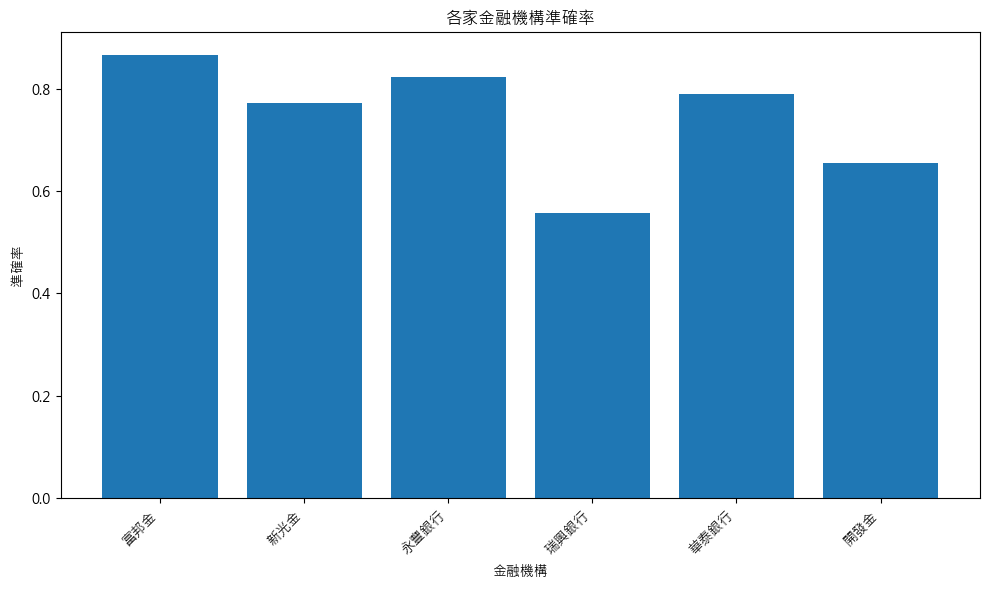

In [31]:
import matplotlib.pyplot as plt

# 假設 inst_results 為一個 dict，格式為：
# { institution: {'correct': 正確題數, 'total': 總題數}, ... }
institutions = list(inst_results.keys())
accuracies = [inst_results[inst]['correct'] / inst_results[inst]['total'] for inst in institutions]

plt.figure(figsize=(10, 6))
plt.bar(institutions, accuracies)
plt.xticks(rotation=45, ha='right')
plt.xlabel("金融機構")
plt.ylabel("準確率")
plt.title("各家金融機構準確率")
plt.tight_layout()
plt.show()


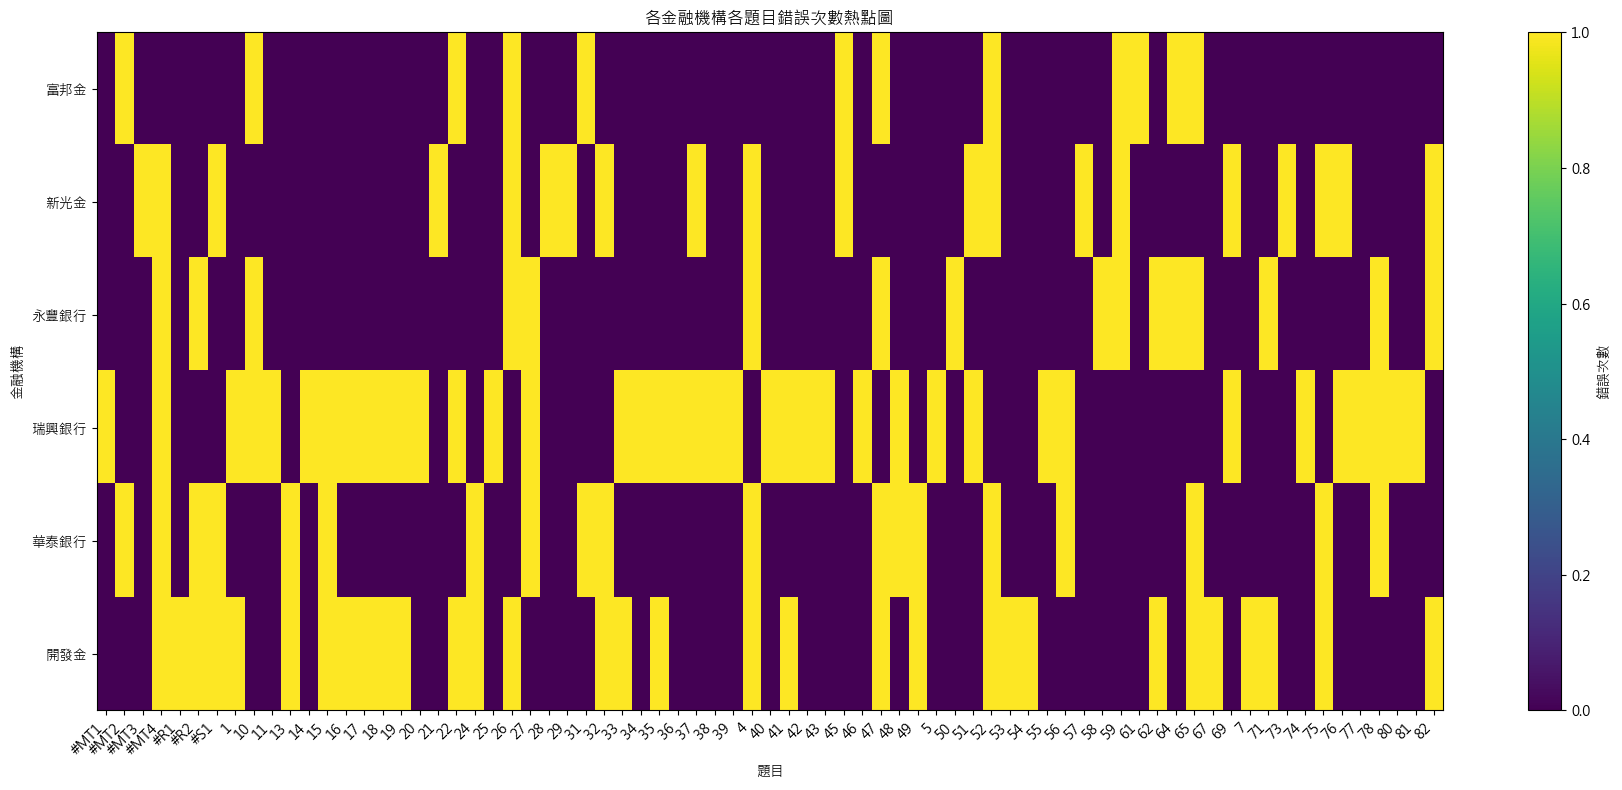

In [39]:
import pandas as pd
import numpy as np

# 先將 inst_errors 轉成一個 DataFrame，包含金融機構與錯誤題目的資訊
error_list = []
for inst, errors in inst_errors.items():
    for err in errors:
        error_list.append({"Institution": inst, "Question": err['Question']})
error_df = pd.DataFrame(error_list)

# 建立樞紐表計算各機構對每個題目的錯誤次數
error_count = error_df.groupby(["Institution", "Question"]).size().unstack(fill_value=0)

plt.figure(figsize=(18, 8))
plt.imshow(error_count, aspect="auto", cmap="viridis")
plt.colorbar(label="錯誤次數")
plt.xticks(range(len(error_count.columns)), error_count.columns, rotation=45, ha='right')
plt.yticks(range(len(error_count.index)), error_count.index)
plt.title("各金融機構各題目錯誤次數熱點圖")
plt.xlabel("題目")
plt.ylabel("金融機構")
plt.tight_layout()
plt.show()
